In [815]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


df = pd.read_csv('data/real_estate_regression.csv')

df['date_created'] = pd.to_datetime(df['date_created'])
df['date_created_first'] = pd.to_datetime(df['date_created_first'])
df['pushed_up_at'] = pd.to_datetime(df['pushed_up_at'], errors='coerce', utc=True)


df['price_per_m2'] = df['price']/df['area_m2']


df.drop_duplicates(subset=['id'], inplace=True)

# we only have SELL type data
df.drop(columns=['transaction_type', 'id', 'date_created', 'date_created_first', 'pushed_up_at'], inplace=True)

df.rename(columns={'location.district': 'district', 'location.latitude': 'latitude',
       'location.longitude': 'longitude'}, inplace=True)

df['building_year'] = np.select([df['building_year']<1800, df['building_year']>2028], [np.nan, np.nan], default=df['building_year'])
df['building_age'] = pd.Timestamp.now().year - df['building_year']


floor_mapping = {
    'CELLAR': -1,
    'GROUND': 0,
    'FIRST': 1,
    'SECOND': 2,
    'THIRD': 3,
    'FOURTH': 4,
    'FIFTH': 5,
    'SIXTH': 6,
    'SEVENTH': 7,
    'EIGHTH': 8,
    'NINTH': 9,
    'TENTH': 10,
    'ABOVE_TENTH': 11,
    'GARRET': 12 
}


df['floor_number'] = df['floor_number'].map(floor_mapping)

# remove outliers, where price=1, etc
df = df[df['estate']=="FLAT"].reset_index(drop=True)

cond1 = df['price_per_m2']>1000
cond2 = df['area_m2']>=10 # 
# remove outliers
cond3 = df['area_m2'] < df['area_m2'].mean() + df['area_m2'].std()*3
cond4 = df['price'] < df['price'].mean() + df['price'].std()*3
cond5 = df['building_floors_num']< df['building_floors_num'].mean() + df['building_floors_num'].std()*3
cond6 = df['price_per_m2']< df['price_per_m2'].mean() + df['price_per_m2'].std()*3

df = df[cond1&cond2&cond3&cond4&cond5&cond6].reset_index(drop=True)




In [817]:
multiplier=2.5
df_clean = df.copy()
columns = ['area_m2', 'price', 'building_floors_num', 'price_per_m2']

for col in columns:

    if col in ['price', 'price_per_m2']:
        values = np.log(df_clean[col])
    else:
        values = df_clean[col]
        
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    if col in ['price', 'price_per_m2']:
        # Convert bounds back from log space
        df_clean = df_clean[
            (np.log(df_clean[col]) >= lower_bound) & 
            (np.log(df_clean[col]) <= upper_bound)
        ]
    else:
        df_clean = df_clean[
            (df_clean[col] >= lower_bound) & 
            (df_clean[col] <= upper_bound)
        ]

df=df_clean

In [818]:
ENABLE_HYPERPARAM_TUNING = True


In [819]:
df[df['price']>2000000].describe()

,latitude,longitude,area_m2,floor_number,building_year,building_floors_num,has_lift,has_internet,has_furniture,has_air_conditioning,...,has_usable_room,has_terrace,has_balcony,has_attic,has_basement,has_garden,has_pool,price,price_per_m2,building_age
count,1450.000000,1450.000000,1450.000000,1447.000000,1346.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.0,1450.000000,1450.000000,1450.0,1.450000e+03,1450.000000,1346.000000
mean,52.213424,21.012716,100.727117,3.337249,1996.150817,5.875862,0.768276,0.454483,0.443448,0.236552,...,0.279310,0.283448,0.578621,0.0,0.277241,0.093103,0.0,2.533017e+06,25584.114320,28.849183
std,0.036020,0.042732,16.020107,2.791687,38.811587,3.321475,0.422079,0.498096,0.496963,0.425111,...,0.448815,0.450828,0.493950,0.0,0.447791,0.290678,0.0,3.744856e+05,4272.547149,38.811587
min,52.116109,20.886242,60.000000,0.000000,1810.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.002000e+06,16474.464580,-2.000000
25%,52.186602,20.982515,89.000000,1.000000,1998.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.236325e+06,22453.848340,2.000000
50%,52.222205,21.011412,100.910000,3.000000,2012.000000,5.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,2.458000e+06,25592.417062,13.000000
75%,52.236121,21.039655,114.000000,5.000000,2023.000000,7.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,2.769000e+06,28834.007102,27.000000
max,52.340940,21.190711,129.000000,11.000000,2027.000000,18.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,3.650000e+06,35823.678253,215.000000


<Axes: >

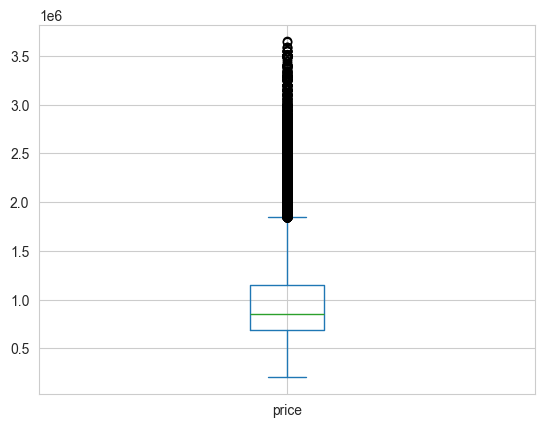

In [820]:
df['price'].plot.box()

# Exploratory

In [821]:
dtypes_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print(dtypes_df)

numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if 'has_' not in col]
summary = df[numeric_cols].describe().T
summary['skew'] = df[numeric_cols].skew()
summary['kurtosis'] = df[numeric_cols].kurtosis()

display(summary)

                     Data Type  Missing Values  Missing Percentage
estate                  object               0                0.00
district                object             504                1.39
latitude               float64               0                0.00
longitude              float64               0                0.00
is_private_owner          bool               0                0.00
advertiser_type         object            1620                4.47
area_m2                float64               0                0.00
rooms_number            object               0                0.00
floor_number           float64             110                0.30
windows_type            object           14868               40.98
heating                 object            8718               24.03
building_year          float64            2712                7.48
building_type           object            6378               17.58
building_floors_num    float64               0                

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
latitude,36278.0,52.232144,0.048032,52.104636,52.197298,52.230600,5.226092e+01,5.236440e+01,0.320233,-0.280918
longitude,36278.0,21.005384,0.067689,20.856116,20.955631,21.006585,2.105198e+01,2.125228e+01,0.273887,0.159062
area_m2,36278.0,54.170906,20.360722,12.000000,39.080000,50.120000,6.414750e+01,1.294000e+02,1.026251,1.127617
floor_number,36168.0,3.024580,2.648405,-1.000000,1.000000,2.000000,4.000000e+00,1.200000e+01,1.151967,0.889082
building_year,33566.0,1995.546237,29.542633,1810.000000,1972.000000,2007.000000,2.023000e+03,2.027000e+03,-0.870920,0.212550
building_floors_num,36278.0,6.185071,3.368049,1.000000,4.000000,5.000000,8.000000e+00,1.800000e+01,0.977707,0.489932
price,36278.0,982487.132742,464039.261296,200000.000000,684659.000000,850000.000000,1.148000e+06,3.650000e+06,1.945990,4.867164
price_per_m2,36278.0,18276.822887,4494.601851,6799.201162,15000.000000,17474.396016,2.066116e+04,3.582368e+04,0.946513,0.952185
building_age,33566.0,29.453763,29.542633,-2.000000,2.000000,18.000000,5.300000e+01,2.150000e+02,0.870920,0.212550


In [822]:
distrincts = df['district'].value_counts()
top_districts = distrincts[distrincts>100][:15].index.values


/var/folders/3r/_0ptqbr15_970chzxcs_tb040000gn/T/ipykernel_50285/3348544734.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data,


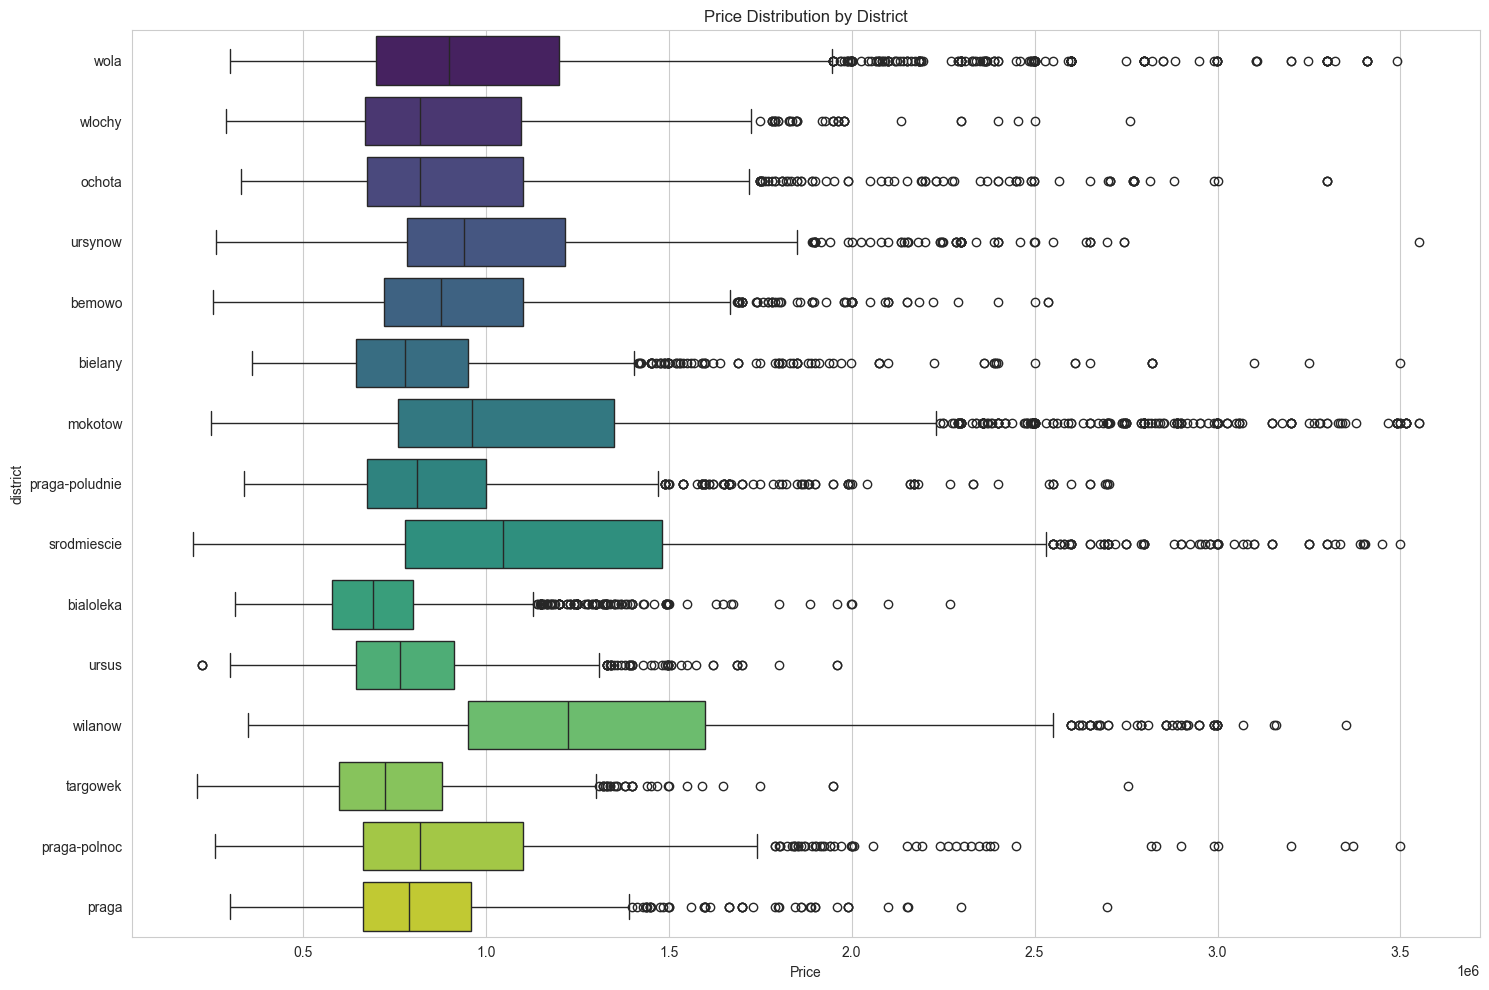

In [823]:
plot_data = df[df['district'].isin(top_districts)].copy()

# Set up the plotting style
sns.set_style("whitegrid")
#plt.style.use('seaborn')

# Create a figure with subplots
fig = plt.figure(figsize=(15, 10))


sns.boxplot(data=plot_data, 
            x='price', 
            y='district',
            orient='h',
            palette='viridis')
plt.title('Price Distribution by District')
plt.xlabel('Price')

# Adjust layout
plt.tight_layout()


<Axes: >

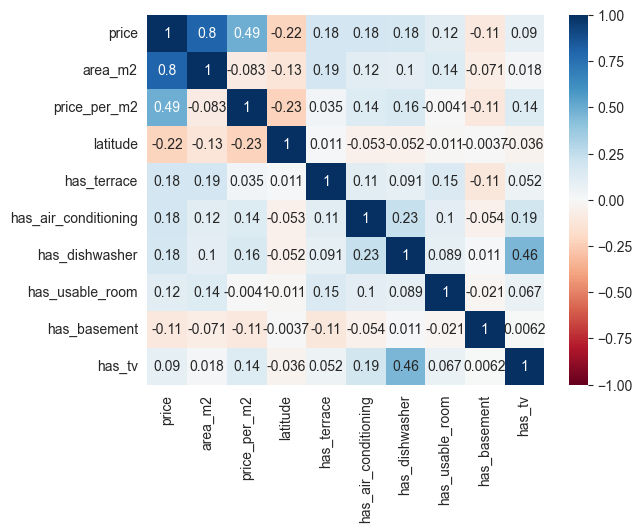

In [824]:
numeric_cols = df.select_dtypes(include=np.number).columns



#plt.figure(figsize=(10, 10))
top_features = df[numeric_cols].corr()['price'].sort_values(ascending=False).abs().nlargest(10)  
top_corr = df[top_features.index].corr()

sns.heatmap(top_corr, 
            annot=True, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1, 
            center=0)

In [784]:
df.groupby(['estate', 'has_balcony']).agg({'price': 'describe'})

price                                                    \
                      count           mean            std       min       25%   
estate has_balcony                                                              
FLAT   0            13806.0  970514.469121  489067.587486  200000.0  649000.0   
       1            22472.0  989842.712751  447822.273280  229000.0  699000.0   

                                                    
                         50%        75%        max  
estate has_balcony                                  
FLAT   0            830000.0  1141504.0  3650000.0  
       1            863000.0  1149000.0  3590000.0

/var/folders/3r/_0ptqbr15_970chzxcs_tb040000gn/T/ipykernel_50285/1409141577.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()
/var/folders/3r/_0ptqbr15_970chzxcs_tb040000gn/T/ipykernel_50285/1409141577.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


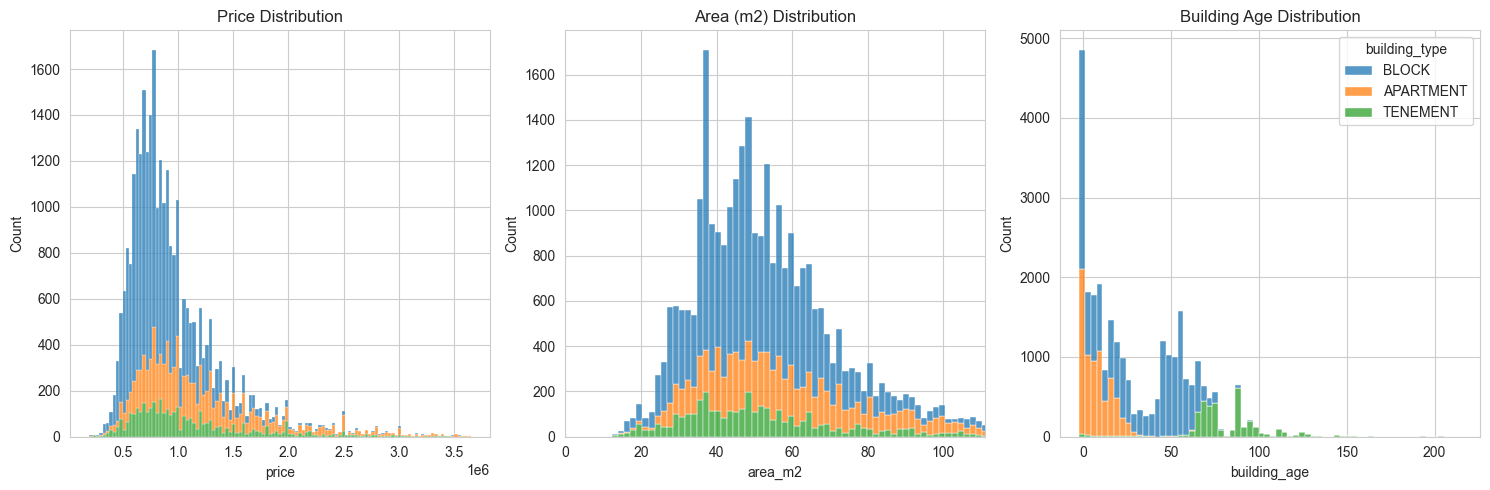

In [828]:
data = df[df['building_type'].isin(['BLOCK', 'APARTMENT', 'TENEMENT'])].reset_index(drop=True)


plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=data, x='price', hue='building_type', multiple="stack")
plt.legend().remove()
plt.title('Price Distribution')

plt.subplot(132)
sns.histplot(data=data, x='area_m2', hue='building_type', multiple="stack")
plt.xlim(0, df['area_m2'].quantile(0.98))
plt.legend().remove()
plt.title('Area (m2) Distribution')

plt.subplot(133)
sns.histplot(data=data, x='building_age', hue='building_type', multiple="stack")
plt.title('Building Age Distribution')

plt.tight_layout()
plt.show()

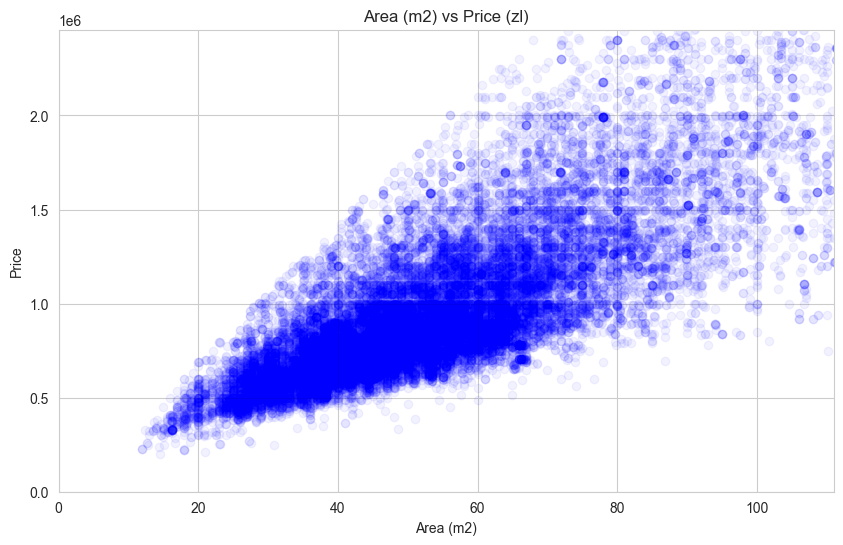

In [786]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.scatter(df['area_m2'], df['price'], color="blue", alpha=0.05)

plt.title('Area (m2) vs Price (zl)')
plt.xlabel('Area (m2)')
plt.ylabel('Price')
plt.xlim(0, df['area_m2'].quantile(0.98))
plt.ylim(0, df['price'].quantile(0.98))
#plt.legend()

plt.show()

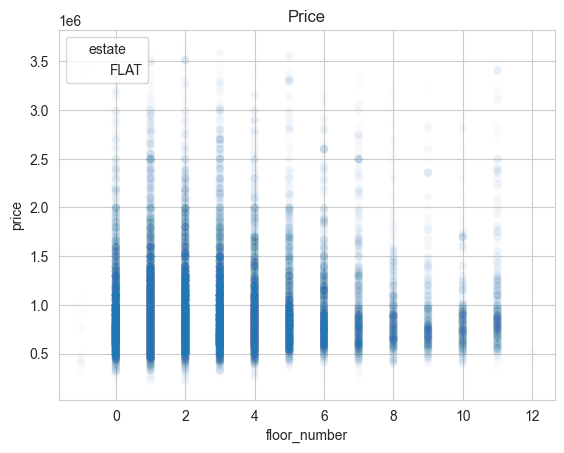

In [787]:
sns.scatterplot(data=df, x='floor_number', y='price', hue='estate', alpha=0.01)
plt.title(f'Price')
#plt.tight_layout()
plt.show()

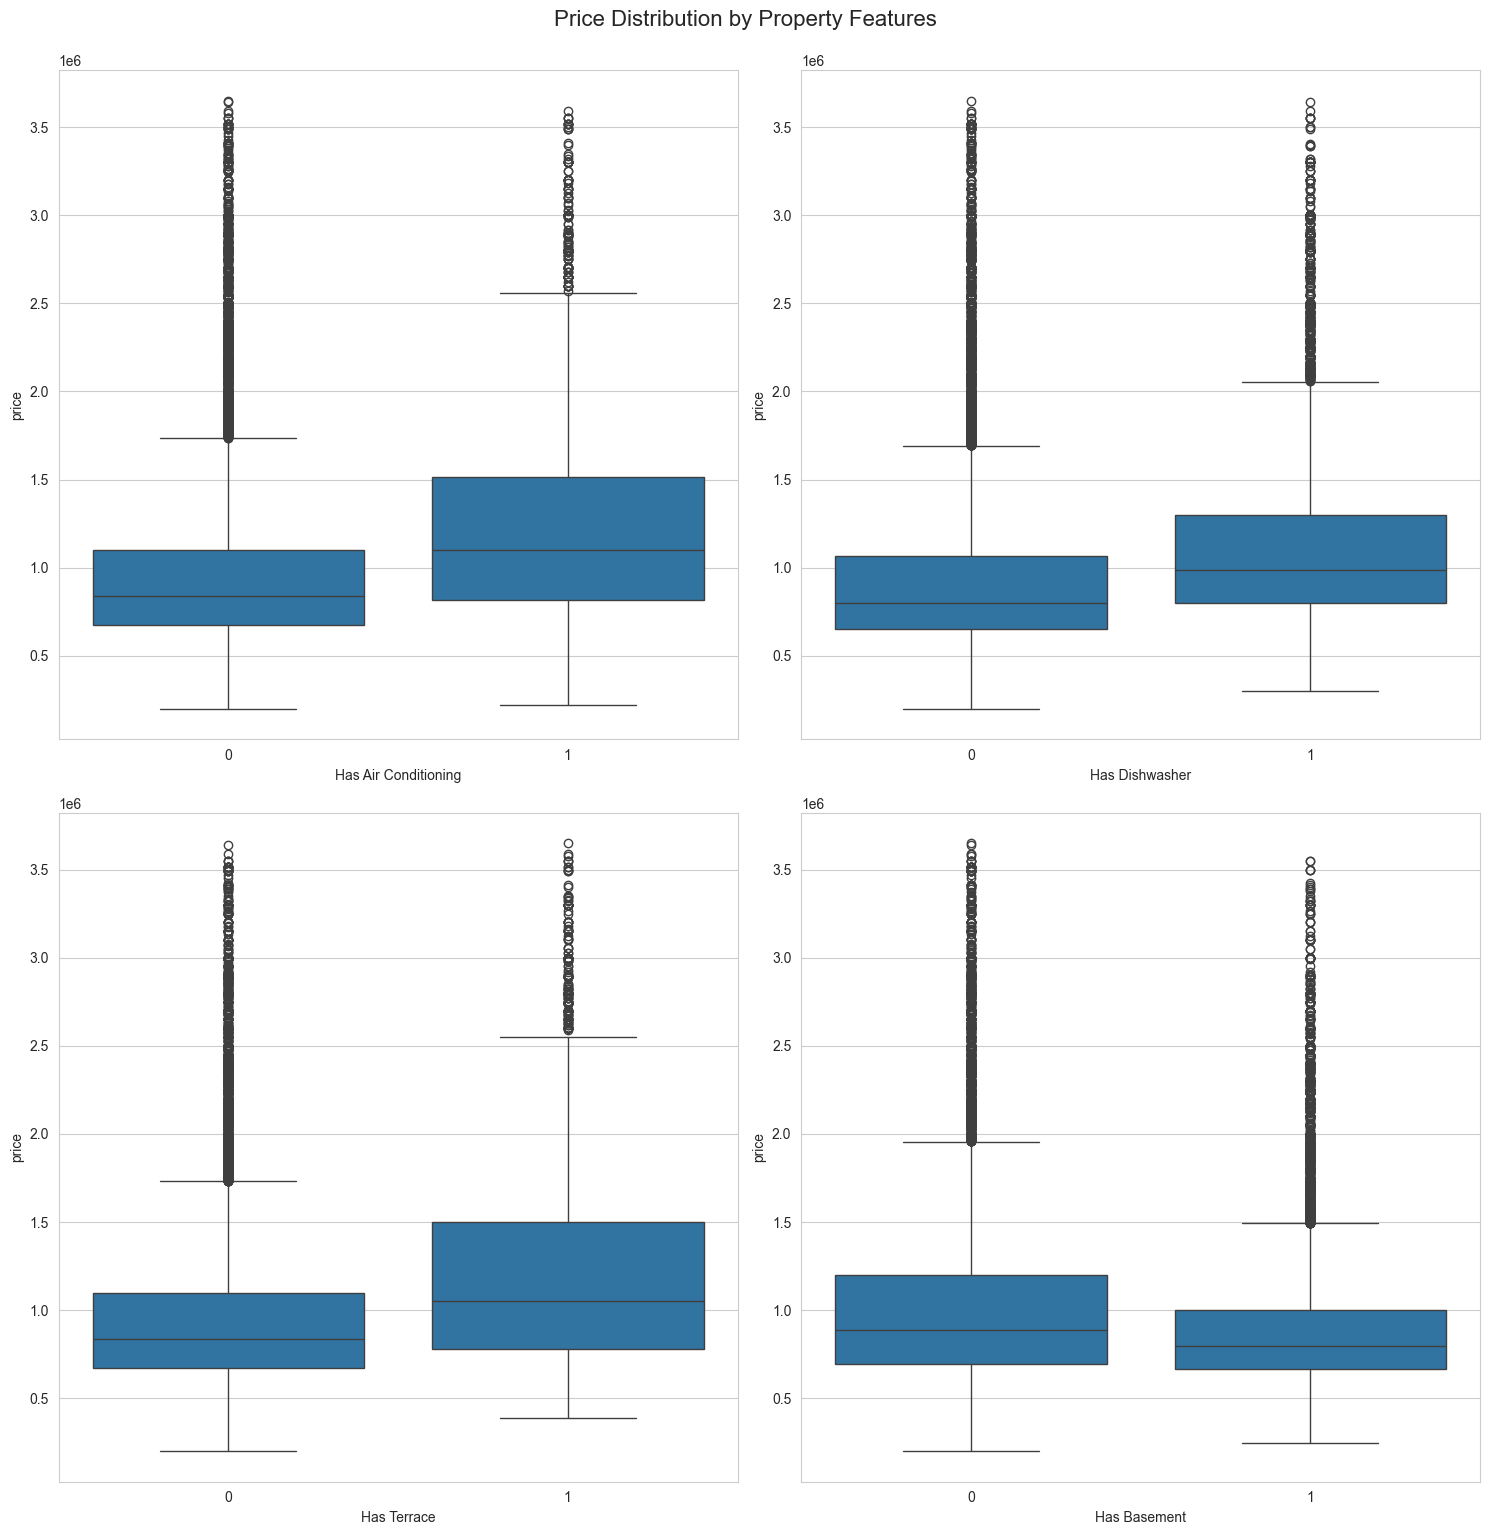

In [788]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Create boxplots for each feature
# Top left
sns.boxplot(data=df, x='has_air_conditioning', y='price', ax=axes[0,0])
#axes[0,0].set_title('Price Distribution by Air Conditioning')
axes[0,0].set_xlabel('Has Air Conditioning')

# Top right
sns.boxplot(data=df, x='has_dishwasher', y='price', ax=axes[0,1])
#axes[0,1].set_title('Dishwasher Boxplot')
axes[0,1].set_xlabel('Has Dishwasher')

# Bottom left
sns.boxplot(data=df, x='has_terrace', y='price', ax=axes[1,0])
#axes[1,0].set_title('Terrace Boxplot')
axes[1,0].set_xlabel('Has Terrace')

# Bottom right
sns.boxplot(data=df, x='has_basement', y='price', ax=axes[1,1])
#axes[1,1].set_title('Basement Boxplot')
axes[1,1].set_xlabel('Has Basement')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title to the figure
fig.suptitle('Price Distribution by Property Features', y=1.02, fontsize=16)

# Show the plot
plt.show()

In [789]:
df.columns

Index(['estate', 'district', 'latitude', 'longitude', 'is_private_owner',
       'advertiser_type', 'area_m2', 'rooms_number', 'floor_number',
       'windows_type', 'heating', 'building_year', 'building_type',
       'building_floors_num', 'floors_num', 'construction_status',
       'building_material', 'building_ownership', 'has_lift', 'has_internet',
       'has_furniture', 'has_air_conditioning', 'has_tv', 'has_oven',
       'has_stove', 'has_dishwasher', 'has_fridge', 'has_washing_machine',
       'has_separate_kitchen', 'has_garage', 'has_usable_room', 'has_terrace',
       'has_balcony', 'has_attic', 'has_basement', 'has_garden', 'has_pool',
       'price', 'price_per_m2', 'building_age'],
      dtype='object')

In [790]:
df

,estate,district,latitude,longitude,is_private_owner,advertiser_type,area_m2,rooms_number,floor_number,windows_type,...,has_usable_room,has_terrace,has_balcony,has_attic,has_basement,has_garden,has_pool,price,price_per_m2,building_age
0,FLAT,wola,52.231839,20.937315,True,PRIVATE,37.00,2,1.0,PLASTIC,...,0,0,1,0,1,0,0,610000.0,16486.486486,55.0
1,FLAT,gorny-mokotow,52.181213,21.026067,True,PRIVATE,54.51,2,4.0,PLASTIC,...,0,0,1,0,0,0,0,1080000.0,19812.878371,16.0
2,FLAT,piaski,52.268537,20.949353,True,PRIVATE,47.00,3,2.0,PLASTIC,...,0,0,1,0,1,0,0,780000.0,16595.744681,52.0
3,FLAT,wlochy,52.211120,20.947930,False,AGENCY,25.00,1,2.0,NaN,...,0,0,1,0,0,0,0,399000.0,15960.000000,7.0
4,FLAT,wlochy,52.193920,20.922610,False,AGENCY,30.90,1,2.0,NaN,...,0,0,1,0,0,0,0,447000.0,14466.019417,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37271,FLAT,praga-poludnie,52.245768,21.104622,False,AGENCY,65.00,3,5.0,NaN,...,0,0,1,0,1,0,0,960000.0,14769.230769,28.0
37272,FLAT,mokotow,52.163980,20.992850,False,AGENCY,43.01,2,3.0,NaN,...,1,0,1,0,0,0,0,980000.0,22785.398744,9.0
37273,FLAT,nowodwory,52.321090,20.938550,False,AGENCY,38.50,2,1.0,NaN,...,0,1,0,0,0,0,0,569000.0,14779.220779,25.0
37274,FLAT,praga,52.228600,21.065010,False,AGENCY,57.00,3,3.0,NaN,...,0,0,1,0,0,0,0,1019000.0,17877.192982,1.0


In [791]:
names_categorical = df.select_dtypes(np.object_).columns

list_name_variable = []
list_levels = []
nan_count = []

for i in range(0,len(names_categorical)):

    name_variable_x =  names_categorical[i] 
    
    levels_x = df[names_categorical [i]].unique()
    
    list_name_variable.append(name_variable_x)
    list_levels.append(levels_x)
    nan_count.append(df[names_categorical [i]].isna().sum())
    
print("String variables and their levels")
d = {'name_variable': list_name_variable, 
     'levels' : list_levels,
     'n_levels': [len(level) for level in list_levels],
     'nan_count': nan_count}

variable_def = pd.DataFrame(data=d)
variable_def

String variables and their levels


,name_variable,levels,n_levels,nan_count
0,estate,[FLAT],1,0
1,district,"[wola, gorny-mokotow, piaski, wlochy, stare-bi...",165,504
2,advertiser_type,"[PRIVATE, AGENCY, nan, DEVELOPER]",4,1620
3,rooms_number,"[2, 3, 1, 4, 5, 6, 7, MORE, 9, 8]",10,0
4,windows_type,"[PLASTIC, nan, ALUMINIUM, WOODEN]",4,14868
5,heating,"[URBAN, nan, GAS, OTHER, BOILER_ROOM, ELECTRIC...",7,8718
6,building_type,"[BLOCK, nan, APARTMENT, TENEMENT, INFILL, HOUS...",8,6378
7,floors_num,[nan],1,36278
8,construction_status,"[READY_TO_USE, TO_COMPLETION, nan, TO_RENOVATION]",4,5618
9,building_material,"[CONCRETE_PLATE, REINFORCED_CONCRETE, OTHER, [...",11,0


In [792]:

categorical_columns = df.select_dtypes(include=['object']).columns

print("We have " + str(len(categorical_columns)) + " columns of type object to encode")
print("Names of the columns that needs to be encoded: "+ "\n" + str(categorical_columns))
df.select_dtypes(include=['object']).head()

We have 11 columns of type object to encode
Names of the columns that needs to be encoded: 
Index(['estate', 'district', 'advertiser_type', 'rooms_number', 'windows_type',
       'heating', 'building_type', 'floors_num', 'construction_status',
       'building_material', 'building_ownership'],
      dtype='object')


,estate,district,advertiser_type,rooms_number,windows_type,heating,building_type,floors_num,construction_status,building_material,building_ownership
0,FLAT,wola,PRIVATE,2,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,CONCRETE_PLATE,NaN
1,FLAT,gorny-mokotow,PRIVATE,2,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,REINFORCED_CONCRETE,FULL_OWNERSHIP
2,FLAT,piaski,PRIVATE,3,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,OTHER,LIMITED_OWNERSHIP
3,FLAT,wlochy,AGENCY,1,NaN,NaN,NaN,NaN,READY_TO_USE,[],FULL_OWNERSHIP
4,FLAT,wlochy,AGENCY,1,NaN,URBAN,APARTMENT,NaN,READY_TO_USE,[],FULL_OWNERSHIP


In [793]:
import unicodedata
import re

def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text
    
    text = str(text).lower()   
   
    # Remove special characters
    text = ''.join(char for char in unicodedata.normalize('NFKD', text)
                  if unicodedata.category(char)[0] != 'P' or char in 'äöüß')
      
    # Replace special characters with underscore
    text = re.sub(r'[^a-z0-9]+', '_', text)
    
    # Remove multiple underscores
    text = re.sub(r'_+', '_', text)
    text = text.strip('_')
    
    return text




for i in range(0,len(categorical_columns)):
    column = categorical_columns[i]
    df[column] = df[column].apply(clean_text)
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column)],axis=1).drop([column],axis=1)



In [794]:
df

,latitude,longitude,is_private_owner,area_m2,floor_number,building_year,building_floors_num,has_lift,has_internet,has_furniture,...,building_material_concreteplate,building_material_hydroton,building_material_other,building_material_reinforcedconcrete,building_material_silikat,building_material_wood,building_ownership_fullownership,building_ownership_limitedownership,building_ownership_share,building_ownership_usufruct
0,52.231839,20.937315,True,37.00,1.0,1970.0,10.0,1,1,0,...,True,False,False,False,False,False,False,False,False,False
1,52.181213,21.026067,True,54.51,4.0,2009.0,16.0,1,1,1,...,False,False,False,True,False,False,True,False,False,False
2,52.268537,20.949353,True,47.00,2.0,1973.0,4.0,0,1,0,...,False,False,True,False,False,False,False,True,False,False
3,52.211120,20.947930,False,25.00,2.0,2018.0,4.0,1,0,1,...,False,False,False,False,False,False,True,False,False,False
4,52.193920,20.922610,False,30.90,2.0,2018.0,4.0,1,1,1,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37271,52.245768,21.104622,False,65.00,5.0,1997.0,5.0,1,1,1,...,False,False,False,False,False,False,False,False,False,False
37272,52.163980,20.992850,False,43.01,3.0,2016.0,7.0,1,1,1,...,False,False,False,False,False,False,True,False,False,False
37273,52.321090,20.938550,False,38.50,1.0,2000.0,5.0,1,1,1,...,False,False,False,False,False,False,True,False,False,False
37274,52.228600,21.065010,False,57.00,3.0,2024.0,4.0,1,1,0,...,False,False,False,False,False,False,True,False,False,False


/var/folders/3r/_0ptqbr15_970chzxcs_tb040000gn/T/ipykernel_50285/489588064.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_corr = pd.concat([high_corr, pd.DataFrame({



Highly correlated feature pairs:
       feature1       feature2  correlation
0  building_age  building_year          1.0

Feature Rankings:
                                     correlation  mutual_info  f_regression  \
area_m2                                 1.000000     1.000000      1.000000   
latitude                                0.265257     0.427435      0.028865   
rooms_number_4                          0.497267     0.066896      0.109349   
longitude                               0.018729     0.404729      0.000338   
rooms_number_1                          0.365549     0.098931      0.055558   
building_age                            0.079976     0.369926      0.003158   
building_year                           0.079976     0.368049      0.003158   
rooms_number_2                          0.340831     0.084869      0.047991   
building_type_block                     0.333727     0.050520      0.045943   
building_type_apartment                 0.332028     0.042053      0.

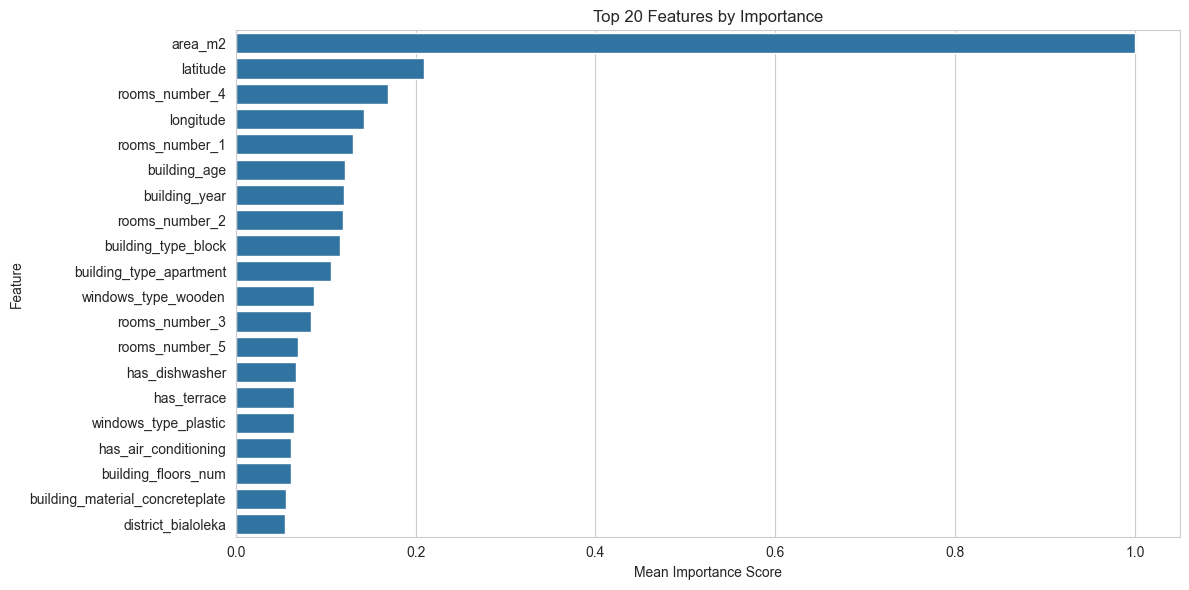

In [796]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

def select_features(X, y, n_features=None):
    """
    Perform feature selection using multiple methods and return a consensus ranking.
    """
    # First, handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Initialize results dictionary
    results = {}
    
    # 1. Correlation with target (using imputed data)
    correlations = abs(X_imputed.corrwith(y))
    results['correlation'] = correlations
    
    # 2. Mutual Information (using scaled, imputed data)
    scaled_data = StandardScaler().fit_transform(X_imputed)
    mi = mutual_info_regression(scaled_data, y)
    results['mutual_info'] = pd.Series(mi, index=X.columns)
    
    # 3. F-regression scores
    f_scores, _ = f_regression(scaled_data, y)
    results['f_regression'] = pd.Series(f_scores, index=X.columns)
    
    # 4. Random Forest feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_imputed, y)
    results['rf_importance'] = pd.Series(rf.feature_importances_, index=X.columns)
    
    # Combine all rankings
    rankings = pd.DataFrame(results)
    
    # Normalize scores between 0 and 1
    for col in rankings.columns:
        rankings[col] = (rankings[col] - rankings[col].min()) / (rankings[col].max() - rankings[col].min())
    
    # Calculate mean score across all methods
    rankings['mean_score'] = rankings.mean(axis=1)
    
    # Sort by mean score
    rankings = rankings.sort_values('mean_score', ascending=False)
    
    # Add missing percentage information
    rankings['missing_pct'] = (X.isnull().sum() / len(X) * 100).round(2)
    
    # Select top features if n_features is specified
    selected_features = list(rankings.index[:n_features]) if n_features else list(rankings.index)
    
    return rankings, selected_features

def plot_feature_importance(rankings, top_n=20):
    """Plot feature importance rankings"""
    plt.figure(figsize=(12, 6))
    
    # Plot top N features
    data = rankings.head(top_n)
    sns.barplot(x='mean_score', y=data.index, data=data)
    
    plt.title(f'Top {top_n} Features by Importance')
    plt.xlabel('Mean Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def analyze_correlations(X, threshold=0.8):
    """Analyze and identify highly correlated features"""
    # First handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Calculate correlation matrix
    corr_matrix = X_imputed.corr().abs()
    
    # Get upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    high_corr = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
    
    for col in upper.columns:
        high_corr_pairs = upper[col][upper[col] > threshold]
        if not high_corr_pairs.empty:
            for idx, corr in high_corr_pairs.items():
                high_corr = pd.concat([high_corr, pd.DataFrame({
                    'feature1': [col],
                    'feature2': [idx],
                    'correlation': [corr]
                })])
    
    return high_corr.sort_values('correlation', ascending=False)

def get_feature_info(X):
    """Get information about features including missing values and unique counts"""
    info = pd.DataFrame({
        'missing_count': X.isnull().sum(),
        'missing_pct': (X.isnull().sum() / len(X) * 100).round(2),
        'unique_count': X.nunique(),
        'unique_pct': (X.nunique() / len(X) * 100).round(2)
    })
    return info.sort_values('missing_pct', ascending=False)




# 1. First check for highly correlated features
high_correlations = analyze_correlations(df[feature_names], threshold=0.8)
print("\nHighly correlated feature pairs:")
print(high_correlations)

# 2. Perform feature selection
rankings, selected_features = select_features(df[feature_names], df[target_variable], n_features=20)  # adjust n_features as needed

# 3. Display results
print("\nFeature Rankings:")
print(rankings)

# 4. Plot feature importance
plot_feature_importance(rankings)


# Modeling

## Split train test data

In [797]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random

random.seed(45564556)

if 'price_per_m2' in df.columns:
    df.drop(columns=['price_per_m2'], inplace=True)


target_variable = "price"
feature_names = df.columns.drop(target_variable)
feature_names = [feat for feat in rankings[:30].index.values if feat != 'price_per_m2']

df_sample = df.sample(30000)

X_train, X_test, Y_train, Y_test = train_test_split(
    df_sample[feature_names], df_sample[target_variable], test_size=0.20)


In [798]:
pd.concat([
    X_train['area_m2'].describe(),
    X_test['area_m2'].describe(),
    Y_train.describe(),
    Y_test.describe()
], axis=1, keys=['area_train', 'area_test', 'price_train', 'price_test'])

,area_train,area_test,price_train,price_test
count,24000.000000,6000.000000,2.400000e+04,6.000000e+03
mean,54.191993,54.166225,9.813752e+05,9.847026e+05
std,20.408115,20.048000,4.631206e+05,4.632865e+05
min,12.000000,12.670000,2.100000e+05,2.580000e+05
25%,39.127500,39.100000,6.850000e+05,6.890000e+05
50%,50.140000,50.465000,8.500000e+05,8.500000e+05
75%,64.270000,64.000000,1.140000e+06,1.150000e+06
max,129.400000,129.000000,3.590000e+06,3.550000e+06


In [799]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error


def get_metrics(Y_test, Y_predict, which=None):
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = root_mean_squared_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)

    if which:
        print(f'{which} metrics')
    metrics = pd.DataFrame({'mse' : [mse], 
                            'rmse':[rmse],
                            'r2':[r2],
                            'mape':[mape], 
                           })
    display(metrics)
    return 

## Decision Tree Regressor

In [800]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_dist = {
    'max_depth': randint(3, 200), 
    'min_samples_split': [5, 10, 20, 50, 100],  
    'min_samples_leaf': [5, 10, 20, 50], 
    'max_leaf_nodes': [10, 20, 30, 50, 100],
    'min_impurity_decrease': uniform(0, 0.1),
    'ccp_alpha': uniform(0, 0.05)
}


if ENABLE_HYPERPARAM_TUNING:

    random_search = RandomizedSearchCV(
        estimator=DecisionTreeRegressor(),
        param_distributions=param_dist,
        n_iter=50,
        scoring='neg_root_mean_squared_error', # neg_root_mean_squared_error, neg_mean_absolute_percentage_error
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE
    )
    

    random_search.fit(X_train, Y_train)
    

    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    print(f"Best score: {random_search.best_score_:.4f}")
    

    best_model = DecisionTreeRegressor(**best_params)
    best_model.fit(X_train, Y_train)
    
else:
    print("Best Hyperparameters:", {})
    best_model = DecisionTreeRegressor()
    best_model.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'ccp_alpha': np.float64(0.002261364445526903), 'max_depth': 42, 'max_leaf_nodes': 100, 'min_impurity_decrease': np.float64(0.038867728968948204), 'min_samples_leaf': 10, 'min_samples_split': 100}
Best score: -205305.5689


In [801]:
Y_predict_train = best_model.predict(X_train)
Y_predict_test = best_model.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,3.784353e+10,194534.131947,0.82355,0.135608


Test metrics


,mse,rmse,r2,mape
0,4.385337e+10,209411.953608,0.795649,0.14098


## XGBoost

In [810]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.8),
    'n_estimators': randint(300, 700),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.8, 0.2), 
    'colsample_bytree': uniform(0.8, 0.2)
}

if ENABLE_HYPERPARAM_TUNING:
    xbg_1 = RandomizedSearchCV(
        estimator=xgb.XGBRegressor(tree_method="hist"),
        param_distributions=param_dist,
        n_iter=50, 
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    
    xbg_1.fit(X_train, Y_train)

else:
    xbg_1 = xgb.XGBRegressor(tree_method="hist", 
                             colsample_bytree= np.float64(0.8500333727943479),
                             learning_rate= np.float64(0.2433278868201498),
                             max_depth=9,
                             min_child_weight= 6,
                             n_estimators= 414,
                             subsample= np.float64(0.9030188114585253)
                            )
xbg_1.best_params_

#xbg_1 = xgb.XGBRegressor(tree_method="hist", eval_metric=mean_absolute_error,)

# xbg_1.fit(X_train, Y_train)

#xbg_1.fit(X_train, Y_train, eval_set=[(X_train, Y_train)])

{'colsample_bytree': np.float64(0.809735648688497),
 'learning_rate': np.float64(0.051255851214134694),
 'max_depth': 9,
 'min_child_weight': 2,
 'n_estimators': 550,
 'subsample': np.float64(0.8652796382019425)}

In [811]:
Y_predict_train = xbg_1.predict(X_train)
Y_predict_test = xbg_1.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,1.380421e+09,37154.012956,0.993564,0.028849


Test metrics


,mse,rmse,r2,mape
0,1.434342e+10,119764.02817,0.933162,0.068616


## RandomForestRegressor

In [808]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['friedman_mse', 'squared_error', 'poisson'], #{'friedman_mse', 'squared_error', 'absolute_error', 'poisson'}
}


rf = RandomForestRegressor(random_state=RANDOM_STATE)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, 
    cv=5,
    scoring='neg_root_mean_squared_error', # neg_mean_absolute_error, neg_root_mean_squared_error, neg_mean_absolute_percentage_error
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 18, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 301}

Best cross-validation score: -143508.763


In [809]:
Y_predict_train = best_rf.predict(X_train)
Y_predict_test = best_rf.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,7.021692e+09,83795.536842,0.967261,0.047757


Test metrics


,mse,rmse,r2,mape
0,1.866846e+10,136632.568888,0.913008,0.077855


## Ensemble

In [837]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


def create_pipeline(model):
    """Create a pipeline with imputer, scaler, and model"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])


def get_models():
    """Return a list of regression models with preprocessing pipelines"""
    models = list()
    
    # Linear models with regularization
    #models.append(('ridge', create_pipeline(Ridge(
   #     alpha=1.0, 
   #     random_state=RANDOM_STATE
   # ))))
    
    models.append(('xgboost', xbg_1))
    
    # Random Forest
    models.append(('rf', create_pipeline(RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))))
    
    # Gradient Boosting
    models.append(('gb', create_pipeline(GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    ))))
    
    return models

def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Evaluate each base model using RMSE and R² score"""
    scores = list()
    results = {}
    
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Convert RMSE to weights (lower RMSE = higher weight)
        weight = 1 / (rmse + 1e-10)
        scores.append(weight)
        results[name] = {'rmse': rmse, 'r2': r2}
        
        print(f'{name:8} - RMSE: {rmse:.2f}, R²: {r2:.3f}')
    
    # Normalize weights
    scores = np.array(scores)
    scores = scores / np.sum(scores)
    
    return scores, results

def train_ensemble(X_train, X_test, y_train, y_test):
    """Train and evaluate the ensemble model"""
    models = get_models()
    weights, results = evaluate_models(models, X_train, X_test, y_train, y_test)
    
    ensemble = VotingRegressor(estimators=models, weights=weights)
    ensemble.fit(X_train, y_train)
    
    y_pred = ensemble.predict(X_test)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ensemble_r2 = r2_score(y_test, y_pred)
    
    print('\nEnsemble Performance:')
    print(f'RMSE: {ensemble_rmse:.2f}')
    print(f'R²: {ensemble_r2:.3f}')
    
    return ensemble, results


# Train and evaluate the ensemble
ensemble_model, model_results = train_ensemble(X_train, X_test, Y_train, Y_test)


xgboost  - RMSE: 120521.57, R²: 0.932
rf       - RMSE: 163855.97, R²: 0.875
gb       - RMSE: 147751.54, R²: 0.898

Ensemble Performance:
RMSE: 131948.55
R²: 0.919


In [838]:
Y_predict_train = ensemble_model.predict(X_train)
Y_predict_test = ensemble_model.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,7.951572e+09,89171.585071,0.962925,0.059201


Test metrics


,mse,rmse,r2,mape
0,1.741042e+10,131948.553646,0.91887,0.079296
